In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
import matplotlib.pyplot as plt

# 1. Data Fetching and Preparation

Fetch historical stock data for a specific ticker

In [4]:
ticker = 'AAPL' # Example: Apple Inc.
data = yf.download(ticker, start='2020-01-01', end='2024-12-31')

# We'll use the 'Close' price for forecasting
data = data[['Close']]
data = data.reset_index() # Reset index to get 'Date' as a column

[*********************100%***********************]  1 of 1 completed


# 2. Data Processing for our LSTM Model
Data Preprocessing for LSTM Steps
- Scale the data.
- Split into Test and Training.
- Backtrack for 3 months or 90 days.
- Reshape to be backtracking window.
- Cast to a PyTorch Tensor.

In [5]:
# Normalize the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data['Close'].values.reshape(-1,1))

# Split data into training and testing sets
training_size = int(len(data_scaled) * 0.80)
test_size = len(data_scaled) - training_size
train_data, test_data = data_scaled[0:training_size,:], data_scaled[training_size:len(data_scaled),:1]

In [6]:
# Function to create sequences for the LSTM
def backtrack_days(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t,t+1,t+2,...t+90 and Y=t+90
time_step = 90
X_train, y_train = backtrack_days(train_data, time_step)
X_test, y_test = backtrack_days(test_data, time_step)


In [7]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

## Build the LSTM Model

In [8]:
# B. LSTM Model Definition
class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=time_step, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

# Train the Model
Train the LSTM Model with 50 Epochs

In [9]:
model = StockLSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 50
for i in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = loss_function(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (i+1) % 10 == 0:
      print(f'LSTM Epoch {i+1}, Loss: {loss.item()}')

LSTM Epoch 10, Loss: 0.11427358537912369
LSTM Epoch 20, Loss: 0.03281769901514053
LSTM Epoch 30, Loss: 0.015770167112350464
LSTM Epoch 40, Loss: 0.010569429956376553
LSTM Epoch 50, Loss: 0.010180944576859474


# Evaluate the Model.

In [10]:
model.eval()
with torch.no_grad():
    train_predict = model(X_train_tensor).numpy()
    test_predict = model(X_test_tensor).numpy()

# Inverse transform to get actual prices
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_orig = scaler.inverse_transform(y_train_tensor.numpy())
y_test_orig = scaler.inverse_transform(y_test_tensor.numpy())

## Train a Classical ARIMA Model
Using Facebook Prophet to build a ARIMA Model to compare to the StockLSTM Model.

In [36]:
data = yf.download(ticker, start='2020-01-01', end='2024-12-31')

data = data[['Close']]
data = data['Close']
data = data.reset_index()
data.rename(columns={'index': 'ds', 'AAPL': 'y'})
data.head()

[*********************100%***********************]  1 of 1 completed


Ticker,Date,AAPL
0,2020-01-02,72.620842
1,2020-01-03,71.914825
2,2020-01-06,72.487846
3,2020-01-07,72.146942
4,2020-01-08,73.307510


In [37]:
# Prophet requires columns 'ds' (datestamp) and 'y' (value)
prophet_data = data.rename(columns={'Date': 'ds', 'AAPL': 'y'})

#prophet_data.index = pd.to_datetime(prophet_data['ds'])
#prophet_data = prophet_data[['y']]

prophet_train = prophet_data.iloc[:training_size]
prophet_test = prophet_data.iloc[training_size:]

# B. Fitting Prophet Model
prophet_model = Prophet(daily_seasonality=True)


In [38]:
print(prophet_train.shape)
prophet_train.head()
print(prophet_train.columns)

(1005, 2)
Index(['ds', 'y'], dtype='object', name='Ticker')


In [39]:
prophet_model.fit(prophet_train)

# C. Prophet Prediction
future = prophet_model.make_future_dataframe(periods=len(prophet_test['y']))
forecast = prophet_model.predict(future)
prophet_predictions = forecast['yhat'][-len(prophet_test):]

14:13:01 - cmdstanpy - INFO - Chain [1] start processing
14:13:01 - cmdstanpy - INFO - Chain [1] done processing


# 4. Model Comparison & Visualization

In [40]:
# A. Performance Metrics
print("\n--- Model Performance ---")
# LSTM Metrics
lstm_train_rmse = np.sqrt(mean_squared_error(y_train_orig, train_predict))
lstm_test_rmse = np.sqrt(mean_squared_error(y_test_orig, test_predict))
print(f"LSTM Train RMSE: {lstm_train_rmse:.2f}")
print(f"LSTM Test RMSE:  {lstm_test_rmse:.2f}")

# Prophet Metrics
prophet_test_rmse = np.sqrt(mean_squared_error(prophet_test['y'], prophet_predictions))
print(f"Prophet Test RMSE: {prophet_test_rmse:.2f}")
print("-------------------------\n")


--- Model Performance ---
LSTM Train RMSE: 20.39
LSTM Test RMSE:  56.21
Prophet Test RMSE: 16.16
-------------------------



In [43]:
data.head()
data = data.rename(columns={'Date': 'Date', 'AAPL': 'Close'})

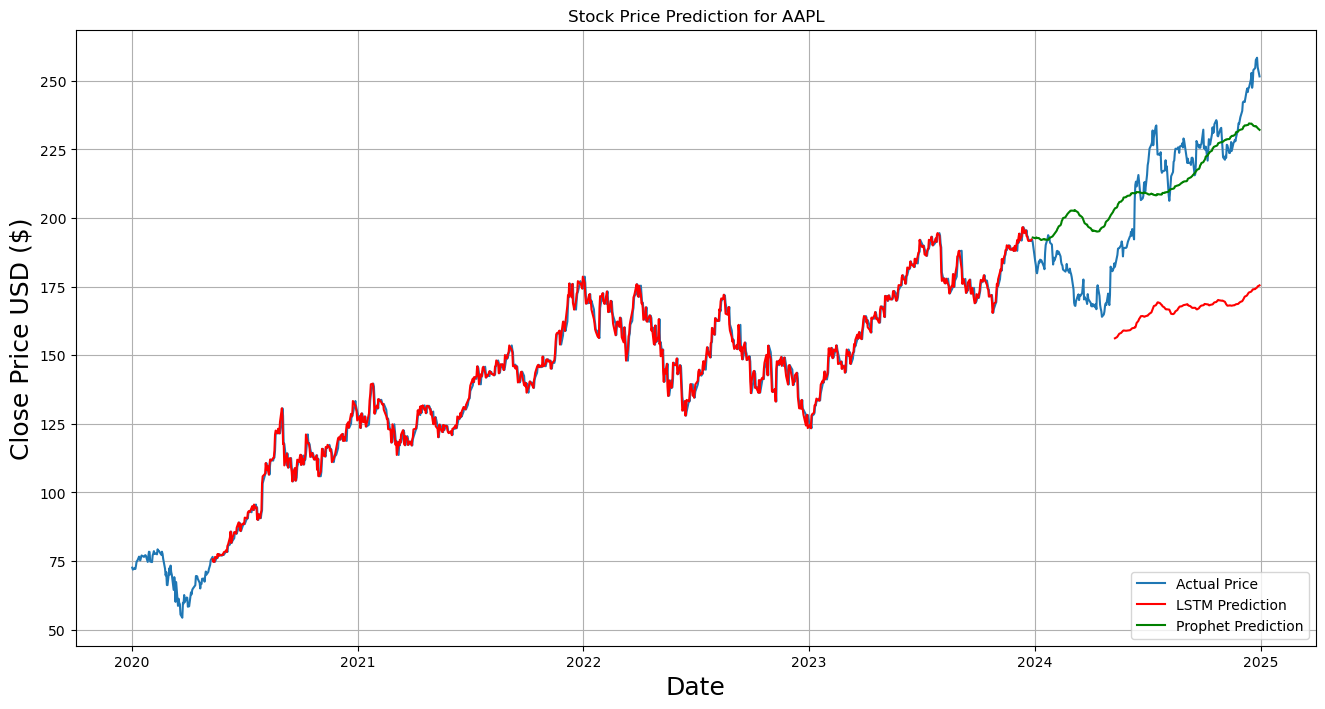

In [55]:
# B. Visualization
plt.figure(figsize=(16,8))
plt.title(f'Stock Price Prediction for {ticker}')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

# Plot actual prices
plt.plot(data['Date'], data['Close'], label='Actual Price')

# Plot LSTM Predictions
lstm_plot_data = np.empty_like(data_scaled)
lstm_plot_data[:, :] = np.nan
lstm_plot_data[time_step-1:len(train_predict)+time_step, :] = scaler.inverse_transform(train_data[time_step:])
lstm_plot_data[len(train_predict)+(time_step*2)+2:len(data_scaled)+2, :] = test_predict
plt.plot(data['Date'], lstm_plot_data, 'r', label='LSTM Prediction')


# Plot Prophet Predictions
plt.plot(prophet_test['ds'], prophet_predictions, 'g', label='Prophet Prediction')

plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Conclusion

The Prophet Model not only trains faster but is also more accurate.

It appears the LSTM is over fitting too much.